####
We should put some if clauses such that if contract expires or there is a release clause our prediction is not made by the model, but we already know the transfer value
###

In [12]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.ensemble  import RandomForestRegressor
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from xgboost import XGBRegressor
import pickle
from tqdm import tqdm

# import k-Means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [13]:
# read files
from pathlib import Path
path = str(Path("andrea_models.ipynb").parent.absolute().parent.absolute()) + "/data/Final/ratings/imputed"
csv_files = glob.glob(os.path.join(path, "*.csv"))

# create one dataframe with ratings_20.csv and ratings_21.csv (train_valid dataframe), and one with ratings_22.csv (test dataframe)
train_valid = pd.concat([pd.read_csv(f) for f in csv_files[1:3]], ignore_index = True)
test = pd.read_csv(csv_files[0])


In [14]:
# save player_name in a variable
short_name_train_valid = train_valid["short_name"]
short_name_test = test["short_name"]

# drop the columns that are not needed
unnecessary_columns = ["short_name", "club_name", "year", "release_clause_eur"]
train_valid = train_valid.drop(unnecessary_columns, axis = 1)
test = test.drop(unnecessary_columns, axis = 1)

# divide value_eur and release_clause_eur by 1000000
train_valid["value_eur"] = train_valid["value_eur"]/1000000
#train_valid["release_clause_eur"] = train_valid["release_clause_eur"]/1000000
test["value_eur"] = test["value_eur"]/1000000
#test["release_clause_eur"] = test["release_clause_eur"]/1000000

# print them in new csv so we can use them in the other notebook
train_valid.to_csv("train_valid.csv", index = False)
test.to_csv("test.csv", index = False)

# define target and features
target = "value_eur"
features = [col for col in train_valid.columns if col != target]

# split into X and y
X_train_valid = train_valid[features]
y_train_valid = train_valid[target]

X_test = test[features]
y_test = test[target]

## Data pre-processing: fees and release clauses

In [15]:
# shapes of the datasets
print("train_valid shape: ", train_valid.shape)
print("test shape: ", test.shape)

train_valid shape:  (34863, 60)
test shape:  (17949, 60)


In [16]:
# display all columns
pd.set_option('display.max_columns', None)
X_train_valid.head()

,overall,potential,wage_eur,age,height_cm,weight_kg,league_level,club_joined,club_contract_valid_until,preferred_foot,weak_foot,skill_moves,international_reputation,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position_A,position_M,position_D,position_G,attack_work_rate,defense_work_rate
0,93.0,93.0,320000.0,34.0,170.0,72.0,1.0,2021.0,2023.0,0.0,4.0,4.0,5.0,85.0,92.0,91.0,95.0,34.0,65.0,85.0,95.0,70.0,91.0,88.0,96.0,93.0,94.0,91.0,96.0,91.0,80.0,91.0,94.0,95.0,86.0,68.0,72.0,69.0,94.0,44.0,40.0,93.0,95.0,75.0,96.0,20.0,35.0,24.0,6.0,11.0,15.0,14.0,8.0,1.0,1.0,0.0,0.0,2.0,1.0
1,92.0,92.0,270000.0,32.0,185.0,81.0,1.0,2021.0,2023.0,1.0,4.0,4.0,5.0,78.0,92.0,79.0,86.0,44.0,82.0,71.0,95.0,90.0,85.0,89.0,85.0,79.0,85.0,70.0,88.0,77.0,79.0,77.0,93.0,82.0,90.0,85.0,76.0,86.0,87.0,81.0,49.0,95.0,81.0,90.0,88.0,35.0,42.0,19.0,15.0,6.0,12.0,8.0,10.0,1.0,0.0,0.0,0.0,3.0,2.0
2,91.0,91.0,270000.0,36.0,187.0,83.0,1.0,2021.0,2023.0,1.0,4.0,5.0,5.0,87.0,94.0,80.0,88.0,34.0,75.0,87.0,95.0,90.0,80.0,86.0,88.0,81.0,84.0,77.0,88.0,85.0,88.0,86.0,94.0,74.0,94.0,95.0,77.0,77.0,93.0,63.0,29.0,95.0,76.0,88.0,95.0,24.0,32.0,24.0,7.0,11.0,15.0,14.0,11.0,1.0,0.0,0.0,0.0,3.0,1.0
3,91.0,91.0,270000.0,29.0,175.0,68.0,1.0,2021.0,2025.0,1.0,5.0,5.0,5.0,91.0,83.0,86.0,94.0,37.0,63.0,85.0,83.0,63.0,86.0,86.0,95.0,88.0,87.0,81.0,95.0,93.0,89.0,96.0,89.0,84.0,80.0,64.0,81.0,53.0,81.0,63.0,37.0,86.0,90.0,93.0,93.0,35.0,32.0,29.0,9.0,9.0,15.0,15.0,11.0,1.0,1.0,0.0,0.0,3.0,2.0
4,91.0,91.0,350000.0,30.0,181.0,70.0,1.0,2021.0,2025.0,1.0,5.0,4.0,4.0,76.0,86.0,93.0,88.0,64.0,78.0,94.0,82.0,55.0,94.0,82.0,88.0,85.0,83.0,93.0,91.0,76.0,76.0,79.0,91.0,78.0,91.0,63.0,89.0,74.0,91.0,76.0,66.0,88.0,94.0,83.0,89.0,68.0,65.0,53.0,15.0,13.0,5.0,10.0,13.0,0.0,1.0,0.0,0.0,3.0,3.0


In [17]:
# correlation between features and target
corr = train_valid.corr()
corr["value_eur"].sort_values(ascending = False)

value_eur                      1.000000
wage_eur                       0.826100
international_reputation       0.622876
overall                        0.581270
potential                      0.548294
movement_reactions             0.513286
mentality_composure            0.412297
passing                        0.406103
dribbling                      0.393739
mentality_vision               0.339266
power_shot_power               0.321252
attacking_short_passing        0.309955
shooting                       0.303887
skill_long_passing             0.292191
skill_ball_control             0.283303
skill_moves                    0.274683
skill_curve                    0.263945
attacking_volleys              0.255041
skill_dribbling                0.250461
power_long_shots               0.248694
mentality_positioning          0.236060
attacking_crossing             0.235033
attacking_finishing            0.231203
skill_fk_accuracy              0.230443
physic                         0.214807


In [18]:
# show how many value_eur are less than 1
train_valid[train_valid["value_eur"] < 1].shape
test[test["value_eur"] < 1].shape

(9218, 60)

In [19]:
# goalkeepers
train_valid[train_valid["position_G"] == 1].head()

,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_level,club_joined,club_contract_valid_until,preferred_foot,weak_foot,skill_moves,international_reputation,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position_A,position_M,position_D,position_G,attack_work_rate,defense_work_rate
5,91.0,93.0,112.0,130000.0,28.0,188.0,87.0,1.0,2021.0,2023.0,1.0,3.0,1.0,5.0,76.021449,54.945481,67.974665,65.293653,57.616630,74.422856,13.0,11.0,15.0,43.0,13.0,12.0,13.0,14.0,40.0,30.0,43.0,60.0,67.0,88.0,49.0,59.0,78.0,41.0,78.0,12.0,34.0,19.0,11.0,65.0,11.0,68.0,27.0,12.0,18.0,87.0,92.0,78.0,90.0,90.0,0.0,0.0,0.0,1.0,2.0,2.0
7,90.0,90.0,13.5,86000.0,35.0,193.0,93.0,1.0,2021.0,2023.0,1.0,4.0,1.0,5.0,80.603660,59.999573,78.435099,75.495296,56.315877,74.301554,15.0,13.0,25.0,60.0,11.0,30.0,14.0,11.0,68.0,46.0,54.0,60.0,51.0,87.0,35.0,68.0,77.0,43.0,80.0,16.0,29.0,30.0,12.0,70.0,47.0,70.0,17.0,10.0,11.0,88.0,88.0,91.0,89.0,88.0,0.0,0.0,0.0,1.0,2.0,2.0
8,90.0,92.0,99.0,250000.0,29.0,187.0,85.0,1.0,2021.0,2025.0,1.0,4.0,1.0,4.0,69.359351,58.445656,79.347851,67.364950,56.761497,75.343565,18.0,14.0,11.0,61.0,14.0,21.0,18.0,12.0,63.0,30.0,38.0,50.0,39.0,86.0,43.0,66.0,79.0,35.0,78.0,10.0,43.0,22.0,11.0,70.0,25.0,70.0,25.0,13.0,10.0,88.0,85.0,88.0,88.0,90.0,0.0,0.0,0.0,1.0,2.0,2.0
12,89.0,91.0,85.5,250000.0,29.0,199.0,96.0,1.0,2021.0,2026.0,0.0,3.0,1.0,4.0,72.666410,57.233446,60.535923,63.220144,55.650758,67.777325,14.0,14.0,13.0,33.0,12.0,13.0,19.0,20.0,35.0,23.0,42.0,52.0,62.0,84.0,45.0,56.0,68.0,38.0,70.0,17.0,23.0,15.0,13.0,44.0,27.0,66.0,20.0,18.0,16.0,84.0,89.0,74.0,86.0,88.0,0.0,0.0,0.0,1.0,2.0,2.0
18,89.0,91.0,94.0,200000.0,27.0,188.0,86.0,1.0,2021.0,2026.0,0.0,3.0,1.0,3.0,87.723040,61.922283,80.461868,72.777612,58.947753,75.020509,20.0,14.0,14.0,61.0,18.0,23.0,15.0,20.0,66.0,40.0,64.0,63.0,60.0,88.0,48.0,70.0,66.0,41.0,78.0,18.0,38.0,27.0,20.0,70.0,51.0,70.0,29.0,15.0,8.0,87.0,82.0,93.0,88.0,88.0,0.0,0.0,0.0,1.0,2.0,2.0


## Define functions that will be used across models

In [20]:
def compute_results(y_pred, y_true):
    """
    Compute the results of the model
    """
    # compute the mean absolute error
    mae = np.mean(abs(y_pred - y_true))
    
    # compute the mean squared error
    mse = np.mean((y_pred - y_true) ** 2)
    
    # compute the root mean squared error
    rmse = np.sqrt(mse)
    
    # compute the mean absolute percentage error
    mape = np.mean(abs((y_pred - y_true) / y_true))
    
    # compute the coefficient of determination
    r2 = 1 - (np.sum((y_pred - y_true) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    # store the results in a dataframe
    results = pd.DataFrame({"mae": [mae], "mse": [mse], "rmse": [rmse], "mape": [mape], "r2": [r2]})

    return results


def plot_results(y_pred, y_true):
    
    # plot both distributions
    figure(figsize = (10, 8))
    plt.hist(y_pred, bins = 100, alpha = 0.5, label = "Predicted")
    plt.hist(y_true, bins = 100, alpha = 0.5, label = "True")
    plt.legend(loc = "upper right")
    plt.title("Predicted vs True Distributions")
    plt.show()

    # plot the predicted vs true
    figure(figsize = (10, 8))
    plt.scatter(y_pred, y_true)
    plt.title("Predicted vs True")
    plt.show()

## Linear Regression

In [21]:
def LinearRegression_model(X_train_valid, y_train_valid, X_test, y_test):

    # define model
    model = LinearRegression()

    # fit the model
    model.fit(X_train_valid, y_train_valid)

    # predict on the test set
    y_pred = model.predict(X_test)
    
    # negative values are not allowed
    y_pred[y_pred < 0] = 0

    # compute the results
    train_results = compute_results(model.predict(X_train_valid), y_train_valid)
    test_results = compute_results(y_pred, y_test)

    # plot the results
    plot_results(y_pred, y_test)

    # store the results in the same dataframe
    results = pd.concat([train_results, test_results], axis = 0)
    # add a column with "training set" and "test set"
    results["set"] = ["train set", "test set"]
    # put this column in the first position
    results = results[["set", "mae", "mse", "rmse", "mape", "r2"]]

    print("Linear Regression Results: ")
    print(results)

    return model

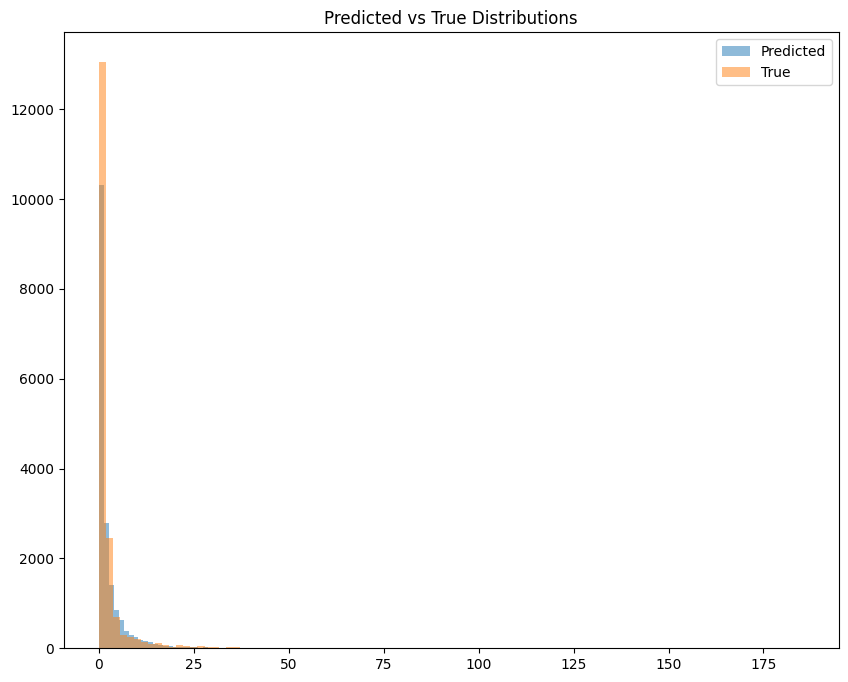

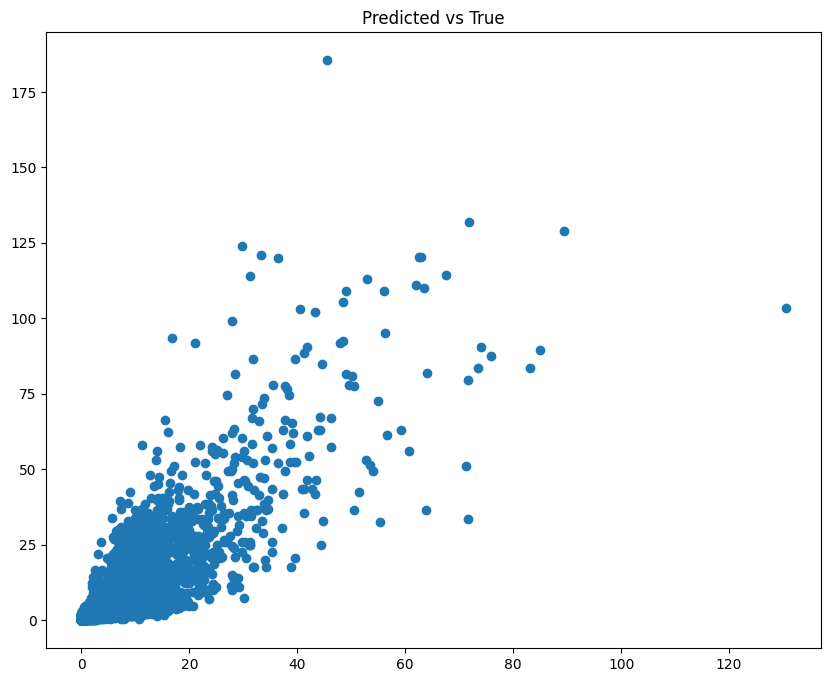

Linear Regression Results: 
         set       mae        mse      rmse      mape        r2
0  train set  1.596818  12.499454  3.535457  2.822661  0.732831
0   test set  1.476132  18.962801  4.354630  0.741995  0.693601


In [22]:
Linear_model = LinearRegression_model(X_train_valid, y_train_valid, X_test, y_test)

In [23]:
# save the model
pickle.dump(Linear_model, open("Linear_model.pkl", "wb"))

# load the model
#Linear_model = pickle.load(open("Linear_model.pkl", "rb"))

## Lasso Regression

In [24]:
def Lasso_model(X_train_valid, y_train_valid, X_test, y_test):

    # define model
    model = LassoCV(cv=5, random_state=0) # 5-fold cross validation to select the best alpha

    # fit the model
    model.fit(X_train_valid, y_train_valid)

    # predict on the test set
    y_pred = model.predict(X_test)

    # negative values are not allowed
    y_pred[y_pred < 0] = 0

    # compute the results
    train_results = compute_results(model.predict(X_train_valid), y_train_valid)
    test_results = compute_results(y_pred, y_test)

    # plot the results
    plot_results(y_pred, y_test)

    # store the results in the same dataframe
    results = pd.concat([train_results, test_results], axis = 0)
    # add a column with "training set" and "test set"
    results["set"] = ["train set", "test set"]
    # put this column in the first position
    results = results[["set", "mae", "mse", "rmse", "mape", "r2"]]

    print("Lasso Regression Results: ")
    print(results)

    return model


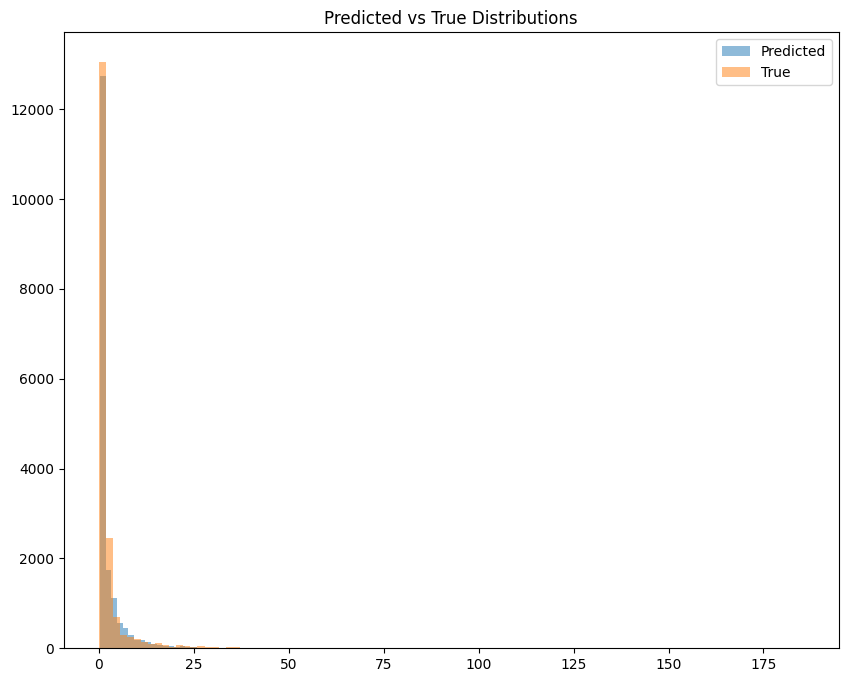

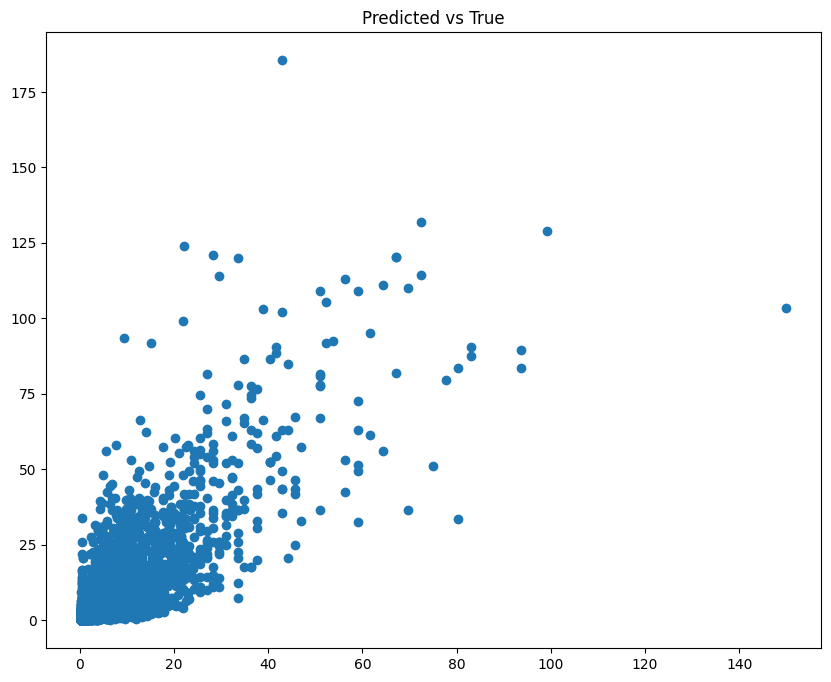

Lasso Regression Results: 
         set       mae        mse      rmse      mape        r2
0  train set  1.423726  14.869853  3.856145  1.085141  0.682165
0   test set  1.612642  22.143003  4.705635  0.893736  0.642216


In [25]:
Lasso_model = Lasso_model(X_train_valid, y_train_valid, X_test, y_test)

## Random Forest

In [26]:
def RandomForest_model(X_train_valid, y_train_valid, X_test, y_test):

    # define model
    model = RandomForestRegressor(n_estimators = 200, random_state=0)

    # define parameters
    parameters = {"max_depth": [10, 15, 20],
                  "min_samples_split": [2, 5, 10],
                  "max_features": [10, 15, 20],
                  }

    # use random search to find the best parameters
    grid = RandomizedSearchCV(model, parameters, cv = 5, n_iter = 10, random_state = 0)

    # use only 10% of the data to speed up the computation
    X_train_valid = X_train_valid.sample(frac = 0.1, random_state = 0)
    y_train_valid = y_train_valid.sample(frac = 0.1, random_state = 0)
    X_test = X_test.sample(frac = 0.1, random_state = 0)
    y_test = y_test.sample(frac = 0.1, random_state = 0)

    # fit the model
    grid.fit(X_train_valid, y_train_valid)

    # predict on the test set
    y_pred = grid.predict(X_test)

    # negative values are not allowed
    y_pred[y_pred < 0] = 0

    # compute the results
    train_results = compute_results(grid.predict(X_train_valid), y_train_valid)
    test_results = compute_results(y_pred, y_test)

    # plot the results
    plot_results(y_pred, y_test)

    # store the results in the same dataframe
    results = pd.concat([train_results, test_results], axis = 0)
    # add a column with "training set" and "test set"
    results["set"] = ["train set", "test set"]
    # put this column in the first position
    results = results[["set", "mae", "mse", "rmse", "mape", "r2"]]

    print("Random Forest Results: ")
    print(results)

    # return results and model
    return grid.best_estimator_


In [27]:
RF_model = RandomForest_model(X_train_valid, y_train_valid, X_test, y_test)

KeyboardInterrupt: 

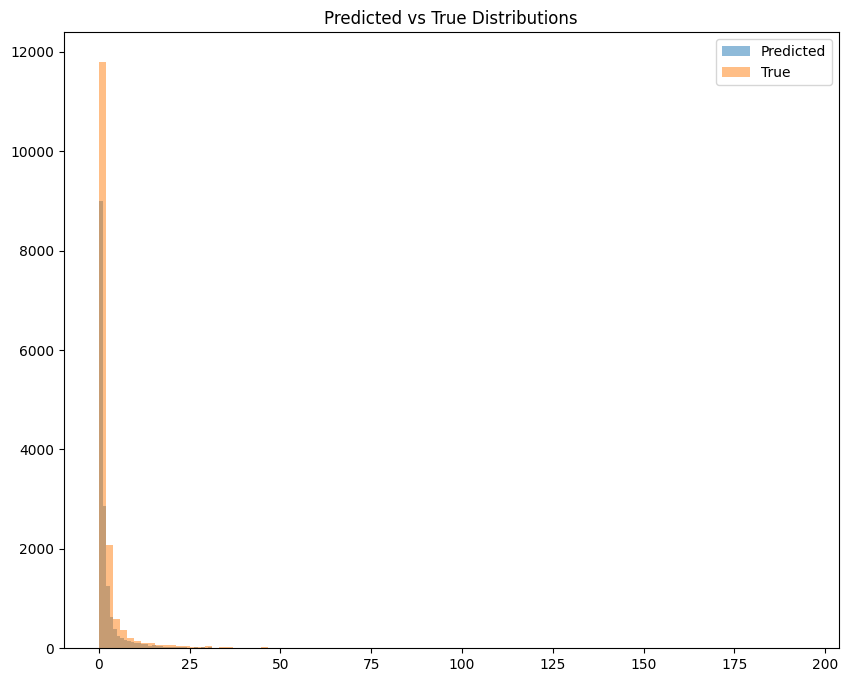

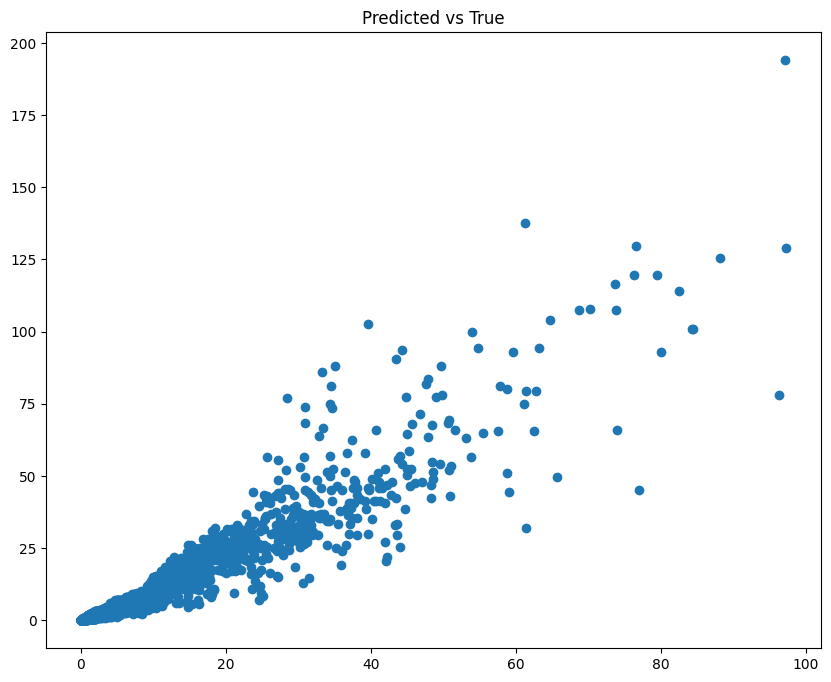

,set,mae,mse,rmse,mape,r2
0,train set,0.539138,4.824902,2.196566,0.24616,0.901082
0,test set,0.604196,7.492135,2.737176,0.18604,0.878312


In [36]:
y_pred = RF_model.predict(X_test)

# compute the results
train_results = compute_results(RF_model.predict(X_train_valid), y_train_valid)
test_results = compute_results(y_pred, y_test)

# plot the results
plot_results(y_pred, y_test)

# store the results in the same dataframe
results = pd.concat([train_results, test_results], axis = 0)
# add a column with "training set" and "test set"
results["set"] = ["train set", "test set"]
# put this column in the first position
results = results[["set", "mae", "mse", "rmse", "mape", "r2"]]

results

In [37]:
# print feature importance of the random forest model
importances = pd.DataFrame({"feature": X_train_valid.columns, "importance": RF_model.feature_importances_})
importances = importances.sort_values("importance", ascending = False)
importances

,feature,importance
0,overall,0.303548
1,potential,0.149766
2,wage_eur,0.134646
28,skill_ball_control,0.094411
32,movement_reactions,0.045456
22,attacking_short_passing,0.038601
15,passing,0.034410
16,dribbling,0.025563
42,mentality_vision,0.022434
24,skill_dribbling,0.013742


In [42]:
# save the model
pickle.dump(RF_model, open("RF_model.pkl", "wb"))

# load the model
#RF_model = pickle.load(open("RF_model.pkl", "rb"))

## XGBoost

In [9]:
def XGBoost_model(X_train_valid, y_train_valid, X_test, y_test):

    #  define model
    model = XGBRegressor(n_estimators = 200, random_state=0)

    # define parameters
    parameters = {"max_depth": [4, 6, 10],
                  "alpha": [0, 0.1, 0.3],
                  "eta": [0.001, 0.1, 0.3],
                  }

    # define random search
    grid = RandomizedSearchCV(model, parameters, cv = 5, n_iter = 10, random_state = 0)

    # use only 10% of the data to speed up the computation
    X_train_valid = X_train_valid.sample(frac = 0.1, random_state = 0)
    y_train_valid = y_train_valid.sample(frac = 0.1, random_state = 0)
    X_test = X_test.sample(frac = 0.1, random_state = 0)
    y_test = y_test.sample(frac = 0.1, random_state = 0)

    # fit the model
    grid.fit(X_train_valid, y_train_valid)

    # predict on the test set
    y_pred = grid.predict(X_test)

    # negative values are not allowed
    y_pred[y_pred < 0] = 0

    # compute the results
    train_results = compute_results(grid.predict(X_train_valid), y_train_valid)
    test_results = compute_results(y_pred, y_test)

    # plot the results
    plot_results(y_pred, y_test)

    # store the results in the same dataframe
    results = pd.concat([train_results, test_results], axis = 0)
    # add a column with "training set" and "test set"
    results["set"] = ["train set", "test set"]
    # put this column in the first position
    results = results[["set", "mae", "mse", "rmse", "mape", "r2"]]

    print("XGBoost Results: ")
    print(results)

    return grid.best_estimator_

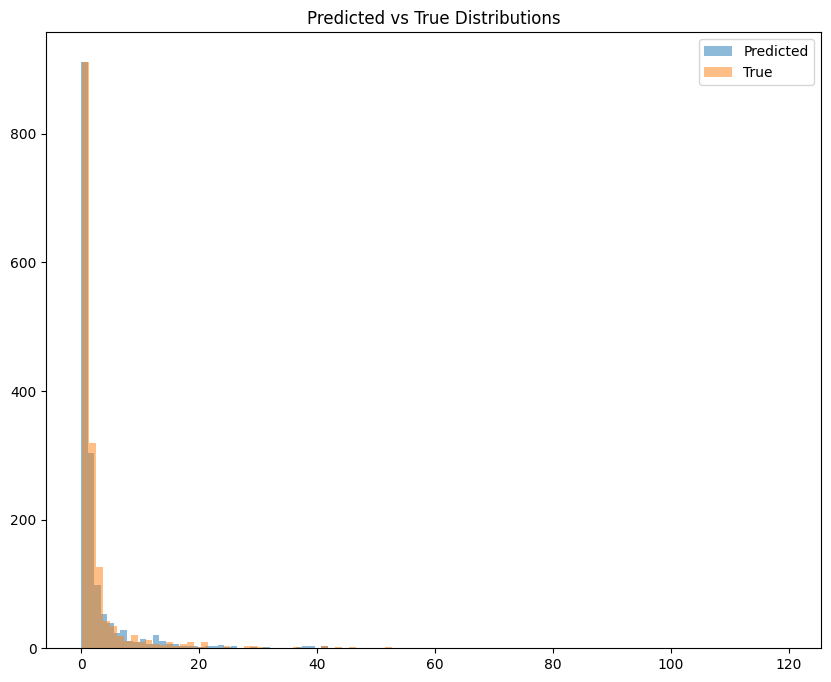

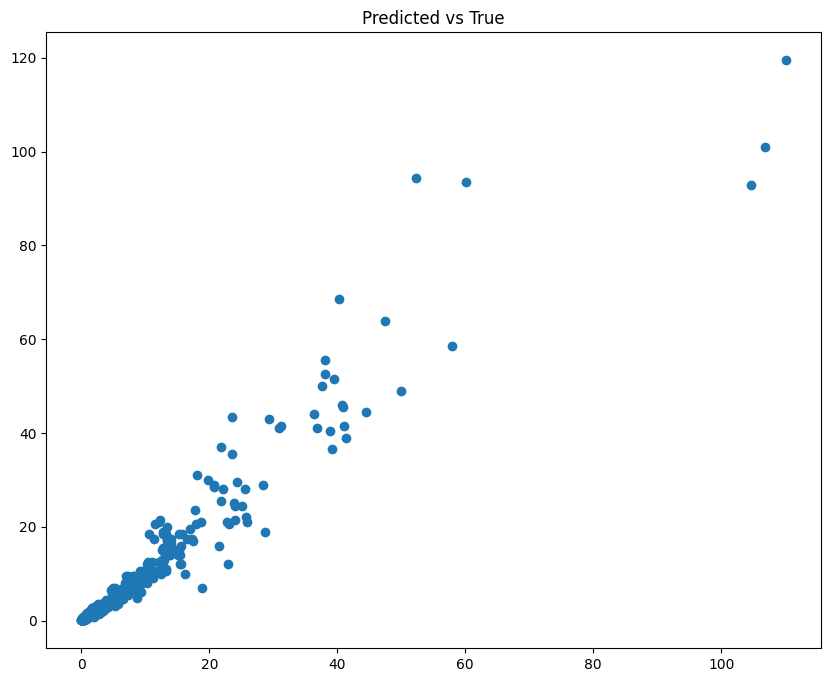

XGBoost Results: 
         set       mae       mse      rmse      mape        r2
0  train set  0.077344  0.011311  0.106353  0.110499  0.999796
0   test set  0.593391  5.193168  2.278852  0.180871  0.930842


In [75]:
XGB_model = XGBoost_model(X_train_valid, y_train_valid, X_test, y_test)

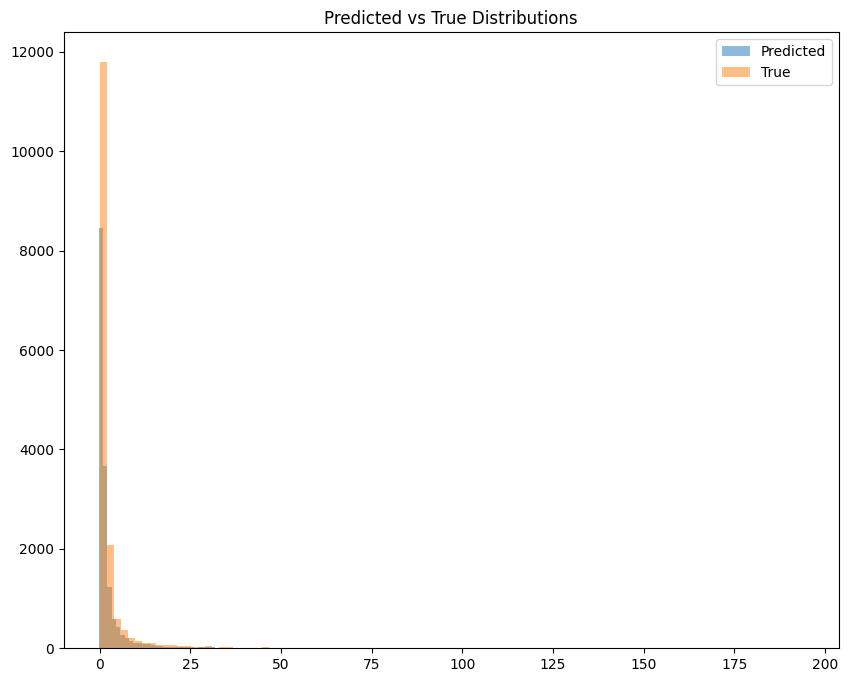

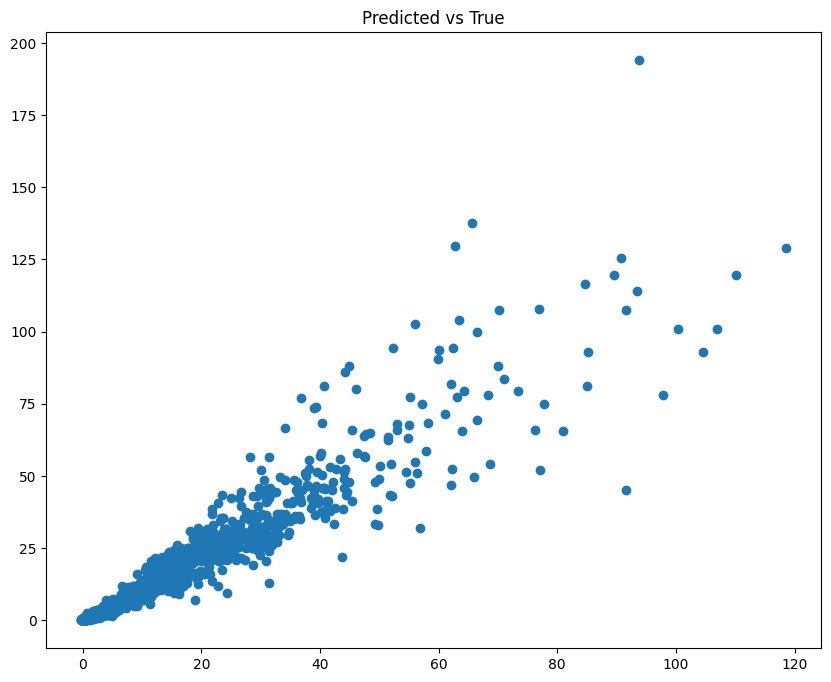

,set,mae,mse,rmse,mape,r2
0,train set,0.495523,4.069560,2.017315,0.230905,0.916568
0,test set,0.513806,5.255883,2.292571,0.188003,0.914633


In [79]:
y_pred = XGB_model.predict(X_test)

# compute the results
train_results = compute_results(XGB_model.predict(X_train_valid), y_train_valid)
test_results = compute_results(y_pred, y_test)

# plot the results
plot_results(y_pred, y_test)

# store the results in the same dataframe
results = pd.concat([train_results, test_results], axis = 0)
# add a column with "training set" and "test set"
results["set"] = ["train set", "test set"]
# put this column in the first position
results = results[["set", "mae", "mse", "rmse", "mape", "r2"]]

results

In [10]:
# save the model
#pickle.dump(XGB_model, open("XGB_model.pkl", "wb"))

# load the model
XGB_model = pickle.load(open("XGB_model.pkl", "rb"))

In [11]:
# print feature importance of the xgboost model
importances = pd.DataFrame({"feature": X_train_valid.columns, "importance": XGB_model.feature_importances_})
importances = importances.sort_values("importance", ascending = False)
importances

,feature,importance
0,overall,0.635352
1,potential,0.084532
28,skill_ball_control,0.075631
4,height_cm,0.036757
3,age,0.016417
13,pace,0.014218
42,mentality_vision,0.013004
58,defense_work_rate,0.012174
21,attacking_heading_accuracy,0.012112
41,mentality_positioning,0.012021


In [12]:
# keep only the features with an importance higher than 0.01
XGB_best_features = importances[importances["importance"] > 0.01]["feature"].values
XGB_best_features

array(['overall', 'potential', 'skill_ball_control', 'height_cm', 'age',
       'pace', 'mentality_vision', 'defense_work_rate',
       'attacking_heading_accuracy', 'mentality_positioning'],
      dtype=object)

## Interpretable Clustering

In [13]:
# Use datasets with only the best features from XGBoost
X_train_valid_xgb = X_train_valid[XGB_best_features]
X_test_xgb = X_test[XGB_best_features]

100%|██████████| 19/19 [02:45<00:00,  8.71s/it]


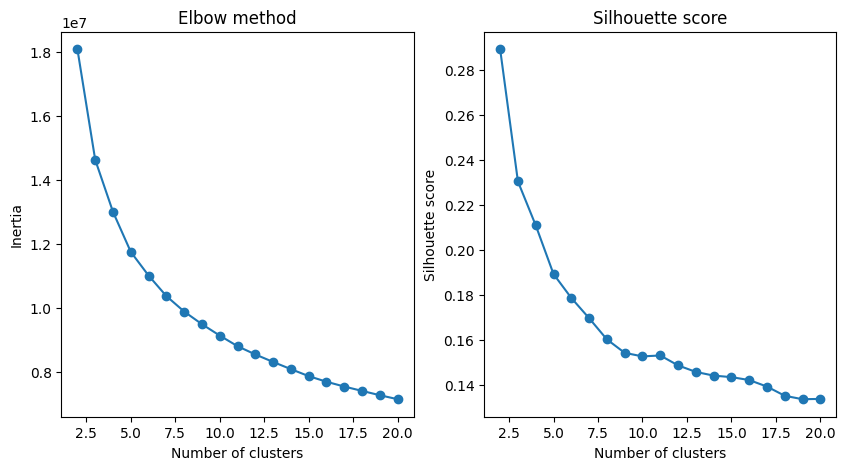

In [17]:
# use Elbow method and silhouette scoreto find the optimal number of clusters

def elbow_and_silhouette(X_train_valid, max_k, random_state = 0):
    scores = []
    inertia = []
    for k in tqdm(range(2, max_k + 1)):
        kmeans = KMeans(n_clusters = k, random_state = random_state)
        kmeans.fit(X_train_valid)
        inertia.append(kmeans.inertia_)
        scores.append(silhouette_score(X_train_valid, kmeans.labels_))

    plt.figure(figsize = (10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k + 1), inertia, marker = "o")
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.title("Elbow method")

    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k + 1), scores, marker = "o")
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette score")
    plt.title("Silhouette score")

    plt.show()

elbow_and_silhouette(X_train_valid_xgb, 20)